# PySpark The Demo

Ran this PySpark shell with

```
/Users/ianmilligan1/dropbox/git/spark-2.1.1-bin-hadoop2.6/bin/pyspark --driver-class-path target/ --jars target/aut-0.16.1-SNAPSHOT-fatjar.jar
```

In [13]:
warcs="/Users/ianmilligan1/dropbox/git/aut-resources/Sample-Data/*.warc.gz"

In [3]:
from pyspark.sql import DataFrame
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

jvm = sc._jvm
loader = jvm.io.archivesunleashed.DataFrameLoader(sc._jsc.sc())

def extract_domain(url):
  url = url.replace('http://', '').replace('https://', '')
  if '/' in url:
    return url.split('/')[0].replace('www.', '')
  else:
    return url.replace('www.', '')

sqlContext.udf.register("extract_domain", extract_domain, StringType())
extract_domain_udf = udf(extract_domain, StringType())

## Let's Start with the Basic Dataframe

In [4]:
pages = DataFrame(loader.extractValidPages("/Users/ianmilligan1/dropbox/git/aut-resources/Sample-Data/*.warc.gz"), sqlContext)

IllegalArgumentException: "Error while instantiating 'org.apache.spark.sql.hive.HiveSessionState':"

In [33]:
pages.printSchema()

root
 |-- CrawlDate: string (nullable = true)
 |-- Url: string (nullable = true)
 |-- MimeType: string (nullable = true)
 |-- Content: string (nullable = true)



In [10]:
pages.select(extract_domain_udf("Url").alias("Domain")) \
  .groupBy("Domain").count().orderBy("count", ascending=False).show()

+--------------------+-----+
|              Domain|count|
+--------------------+-----+
|       equalvoice.ca| 4629|
|          liberal.ca| 1968|
|       greenparty.ca|  693|
|policyalternative...|  584|
|         fairvote.ca|  465|
|              ndp.ca|  415|
|     davidsuzuki.org|  362|
|     canadiancrc.com|   83|
|         youtube.com|    8|
|v18.lscache5.c.yo...|    1|
|              gca.ca|    1|
|          flickr.com|    1|
|v7.lscache3.c.you...|    1|
|   communitywalk.com|    1|
+--------------------+-----+



In [14]:
links = DataFrame(loader.extractHyperlinks(warcs), sqlContext)

In [32]:
links.printSchema()

root
 |-- CrawlDate: string (nullable = true)
 |-- Src: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Anchor: string (nullable = true)



In [16]:
links.select(extract_domain_udf("Src").alias("SrcDomain"), extract_domain_udf("Dest").alias("DestDomain")) \
  .groupBy("SrcDomain", "DestDomain").count().orderBy("count", ascending=False).show()

+---------------+--------------------+------+
|      SrcDomain|          DestDomain| count|
+---------------+--------------------+------+
|     liberal.ca|          liberal.ca|103668|
|  equalvoice.ca|       equalvoice.ca| 17036|
|         ndp.ca|              ndp.ca| 15311|
|davidsuzuki.org|     davidsuzuki.org| 13903|
|  greenparty.ca|       greenparty.ca|  9715|
|  equalvoice.ca|       snapdesign.ca|  4259|
|  equalvoice.ca|gettingtothegate.com|  4259|
|  equalvoice.ca|         thestar.com|  4259|
|     liberal.ca|         twitter.com|  3936|
|canadiancrc.com|translate.google.com|  2584|
|     liberal.ca|       liberal.ns.ca|  1968|
|     liberal.ca|             plcq.ca|  1968|
|     liberal.ca|      saskliberal.ca|  1968|
|     liberal.ca|liberalpartyofcan...|  1968|
|     liberal.ca|           lpcbc.com|  1968|
|     liberal.ca|        facebook.com|  1968|
|     liberal.ca|   liberalalberta.ca|  1968|
|     liberal.ca|             lpco.ca|  1968|
|     liberal.ca|      pei.liberal

## Now let's do Pandas

In [22]:
pdf=links.select(extract_domain_udf("Src").alias("SrcDomain"), extract_domain_udf("Dest").alias("DestDomain")) \
  .groupBy("SrcDomain", "DestDomain").count().orderBy("count", ascending=False).toPandas()

In [45]:
pdf.head()

,SrcDomain,DestDomain,count
0,liberal.ca,liberal.ca,103668
1,equalvoice.ca,equalvoice.ca,17036
2,ndp.ca,ndp.ca,15311
3,davidsuzuki.org,davidsuzuki.org,13903
4,greenparty.ca,greenparty.ca,9715


In [25]:
freq=pages.select(extract_domain_udf("Url").alias("Domain")) \
  .groupBy("Domain").count().orderBy("count", ascending=False).toPandas()

In [46]:
freq.head()

,Domain,count
0,equalvoice.ca,4629
1,liberal.ca,1968
2,greenparty.ca,693
3,policyalternatives.ca,584
4,fairvote.ca,465


## Now Let's Visualize it!

In [19]:
%matplotlib inline
import matplotlib

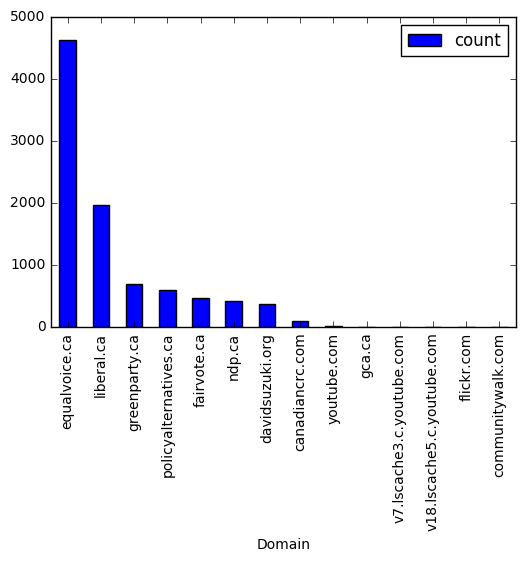

In [31]:
freq.plot(x='Domain', kind='bar')

In [41]:
import networkx as nx

In [42]:
pdf.head()

,SrcDomain,DestDomain,count
0,liberal.ca,liberal.ca,103668
1,equalvoice.ca,equalvoice.ca,17036
2,ndp.ca,ndp.ca,15311
3,davidsuzuki.org,davidsuzuki.org,13903
4,greenparty.ca,greenparty.ca,9715


In [43]:
graph=nx.from_pandas_dataframe(pdf,source='SrcDomain',target='DestDomain')

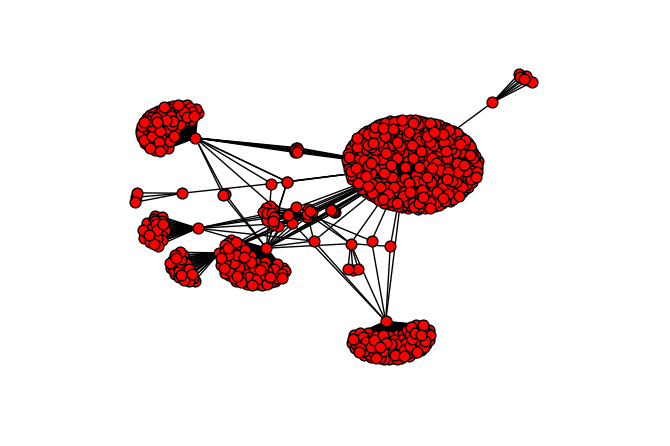

In [179]:
nx.draw(graph, layout=nx.spring_layout(graph),node_size=60,font_size=8)

## Word Clouds!

In [167]:
output=pages.select("Content").toPandas()

In [168]:
output.head()

,Content
0,HTTP/1.1 200 OK\r\nConnection: close\r\nDate: ...
1,HTTP/1.1 200 OK\r\nCache-Control: private\r\nC...
2,"HTTP/1.1 200 OK\r\nDate: Fri, 18 Dec 2009 23:1..."
3,HTTP/1.1 200 OK\r\nConnection: close\r\nDate: ...
4,HTTP/1.1 200 OK\r\nCache-Control: private\r\nC...


In [51]:
import nltk

In [54]:
from bs4 import BeautifulSoup

In [107]:
from os import path
from wordcloud import WordCloud

In [169]:
wordcloud = WordCloud().generate(text)

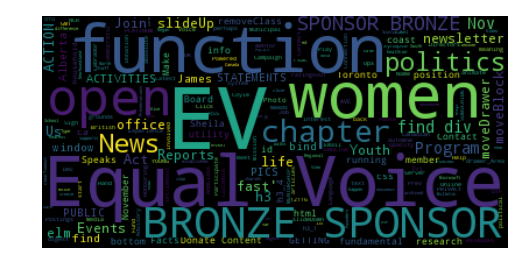

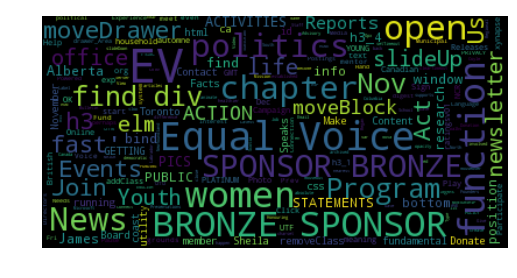

In [109]:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()